In [1]:
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras.layers as layers
import scipy as sc

In [2]:
img_size=(240, 320)
img_channels = 3
batch_size=32
epochs = 50
display_epochs = (0, 100)


In [3]:
model_name = 'depthwise_(32-64-126_256)3_(NaN).tf'

In [4]:
train_size = 1000
validation_size = 500
test_size = 500

# Load the DataSet

Dataset citation:
- From Semi-Supervised to Transfer Counting of Crowds
C. C. Loy, S. Gong, and T. Xiang
in Proceedings of IEEE International Conference on Computer Vision, pp. 2256-2263, 2013 (ICCV)
- Cumulative Attribute Space for Age and Crowd Density Estimation
K. Chen, S. Gong, T. Xiang, and C. C. Loy
in Proceedings of IEEE Conference on Computer Vision and Pattern Recognition, pp. 2467-2474, 2013 (CVPR, Oral)
- Crowd Counting and Profiling: Methodology and Evaluation
C. C. Loy, K. Chen, S. Gong, T. Xiang
in S. Ali, K. Nishino, D. Manocha, and M. Shah (Eds.), Modeling, Simulation and Visual Analysis of Crowds, Springer, vol. 11, pp. 347-382, 2013
- Feature Mining for Localised Crowd Counting
K. Chen, C. C. Loy, S. Gong, and T. Xiang
British Machine Vision Conference, 2012 (BMVC)

In [5]:
dataset_path = '/Users/olove/Library/CloudStorage/OneDrive-Personal/AI datasets/CrowdCounter'

In [6]:
labels_df = pd.read_csv(dataset_path + '/labels.csv')
labels_df['image_name'] = labels_df['id'].map('seq_{:06d}.jpg'.format)
labels_df.drop("id", axis=1,inplace=True)
display(labels_df)

,count,image_name
0,35,seq_000001.jpg
1,41,seq_000002.jpg
2,41,seq_000003.jpg
3,44,seq_000004.jpg
4,41,seq_000005.jpg
...,...,...
1995,27,seq_001996.jpg
1996,27,seq_001997.jpg
1997,25,seq_001998.jpg
1998,26,seq_001999.jpg


In [7]:
labels_df = labels_df.sample(frac=1).reset_index(drop=True)
display(labels_df)

,count,image_name
0,30,seq_001312.jpg
1,31,seq_001860.jpg
2,29,seq_001808.jpg
3,42,seq_001332.jpg
4,25,seq_000943.jpg
...,...,...
1995,24,seq_001049.jpg
1996,26,seq_000634.jpg
1997,38,seq_000923.jpg
1998,30,seq_001460.jpg


In [8]:
if (train_size+validation_size+test_size) != len(labels_df):
    print('Dataset size is different from specified class sizes')
    exit(1)

training_df = labels_df[:train_size]
validation_df = labels_df[train_size:train_size+validation_size].reset_index(drop=True)
test_df = labels_df[train_size+validation_size:].reset_index(drop=True)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    
)

x_col_name = 'image_name'
y_col_name = 'count'

train_generator = datagen.flow_from_dataframe(
    training_df, 
    dataset_path + '/frames/frames/',
    x_col=x_col_name,
    y_col=y_col_name,
    class_mode='raw',
    target_size=img_size,
    batch_size=batch_size,
)

validation_generator = datagen.flow_from_dataframe(
    validation_df,
    dataset_path + '/frames/frames/',
    x_col=x_col_name,
    y_col=y_col_name,
    class_mode='raw',
    target_size=img_size,
    batch_size=batch_size,
)

test_generator = datagen.flow_from_dataframe(
    test_df,
    dataset_path + '/frames/frames/',
    x_col=x_col_name,
    y_col=y_col_name,
    class_mode='raw',
    target_size=img_size,
    batch_size=batch_size,
)

Found 1000 validated image filenames.
Found 500 validated image filenames.
Found 500 validated image filenames.


# Define the model

In [10]:
inputs = keras.Input(shape= img_size + (img_channels,))

## Custom Simple Covnet

Downsizing using strides instead of MaxPolling in order to conserve location data

In [11]:
def basic_covnet_block(input):
    x = layers.Conv2D(filters=32, kernel_size=3, strides=2, activation="relu")(inputs)
    x = layers.Conv2D(filters=64, kernel_size=3, strides=2, activation="relu")(x)
    x = layers.Conv2D(filters=128, kernel_size=3, strides=2, activation="relu")(x)
    return x

## Custom Depthwise Seperable Convolution

In [12]:
def custom_depthwise_conv_block(input, sizes, repeat_per_size, stride = 1, pooling = False, dropout = False, residual = False):
    x = input

    previous_block_activation = x
    
    for size in sizes:
        for i in range(repeat_per_size - 1):
            x = layers.BatchNormalization()(x)
            x  = layers.Activation("relu")(x)
            x = layers.SeparableConv2D(size, 3, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x  = layers.Activation("relu")(x)
        if dropout:
            x = layers.Dropout(0.5)(x)
        x = layers.SeparableConv2D(size, 3, stride=1 if pooling else stride, padding='same', use_bias=False)(x)
        if pooling:
            x = layers.MaxPooling2D(3, strides=stride, padding='same')(x)
        if residual:
            residual = layers.Conv2D(size, 1, strides=2, padding="same")(
                previous_block_activation
            )
            x = layers.add([x, residual])
            previous_block_activation = x



    return x
        

# Output Layer

In [13]:
def basic_dense_block(covnet_param, sizes):
    x = layers.Flatten()(covnet_param)
    x = layers.Dropout(0.5)(x)
    for size in sizes:
        x = layers.Dense(size, activation="relu")(x)
        x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1)(x)
    return outputs

In [14]:

covnet = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(inputs)
covnet = custom_depthwise_conv_block(covnet, [32, 64], 3, stride=2, pooling=True, residual=True)
covnet = custom_depthwise_conv_block(covnet, [128], 3, residual=True)
outputs = basic_dense_block(covnet, [])
model = keras.Model(inputs=inputs, outputs=outputs)

2023-12-14 12:06:10.801918: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-14 12:06:10.801952: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-14 12:06:10.801959: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-14 12:06:10.802225: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-14 12:06:10.802501: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 320, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 236, 316, 32)      2400      
                                                                 
 batch_normalization (Batch  (None, 236, 316, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 236, 316, 32)      0         
                                                                 
 separable_conv2d (Separabl  (None, 236, 316, 32)      1312      
 eConv2D)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 236, 316, 32)      128   

# Train model

In [16]:
model.compile(loss="mse", optimizer="adam", metrics=["mae"])
# TODO: Try mae vs accuracy. mae should be better since we are adjusting it to get closer to the actual value

In [17]:
callbacks_list = [
#    keras.callbacks.EarlyStopping(
#        monitor="val_loss", patience=4
#    ),
    keras.callbacks.ModelCheckpoint(
        filepath=model_name,
        monitor="val_loss",
        save_best_only=True
    ),
#    keras.callbacks.TensorBoard()
]

In [18]:
Wsave = model.get_weights()

In [19]:
model.set_weights(Wsave)
history = model.fit(train_generator,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
)

Epoch 1/50


2023-12-14 12:06:12.392454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - ETA: 0s - loss: 140.5412 - mae: 8.0855INFO:tensorflow:Assets written to: depthwise_(32-64-126_256)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126_256)3_(NaN).tf/assets


32/32 [==============================] - 27s 747ms/step - loss: 140.5412 - mae: 8.0855 - val_loss: 961.0762 - val_mae: 30.2772
Epoch 2/50
32/32 [==============================] - ETA: 0s - loss: 11.0190 - mae: 2.6095INFO:tensorflow:Assets written to: depthwise_(32-64-126_256)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126_256)3_(NaN).tf/assets


32/32 [==============================] - 23s 717ms/step - loss: 11.0190 - mae: 2.6095 - val_loss: 953.5417 - val_mae: 30.1525
Epoch 3/50
32/32 [==============================] - ETA: 0s - loss: 7.3708 - mae: 2.1604INFO:tensorflow:Assets written to: depthwise_(32-64-126_256)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126_256)3_(NaN).tf/assets


32/32 [==============================] - 24s 728ms/step - loss: 7.3708 - mae: 2.1604 - val_loss: 942.6321 - val_mae: 29.9710
Epoch 4/50
32/32 [==============================] - ETA: 0s - loss: 5.8918 - mae: 1.9392INFO:tensorflow:Assets written to: depthwise_(32-64-126_256)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126_256)3_(NaN).tf/assets


32/32 [==============================] - 24s 746ms/step - loss: 5.8918 - mae: 1.9392 - val_loss: 929.0653 - val_mae: 29.7439
Epoch 5/50
32/32 [==============================] - ETA: 0s - loss: 5.8360 - mae: 1.9275INFO:tensorflow:Assets written to: depthwise_(32-64-126_256)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126_256)3_(NaN).tf/assets


32/32 [==============================] - 25s 739ms/step - loss: 5.8360 - mae: 1.9275 - val_loss: 921.0342 - val_mae: 29.6085
Epoch 6/50
32/32 [==============================] - ETA: 0s - loss: 5.0614 - mae: 1.8013INFO:tensorflow:Assets written to: depthwise_(32-64-126_256)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126_256)3_(NaN).tf/assets


32/32 [==============================] - 24s 729ms/step - loss: 5.0614 - mae: 1.8013 - val_loss: 908.7640 - val_mae: 29.4006
Epoch 7/50
32/32 [==============================] - ETA: 0s - loss: 2.5742 - mae: 1.2042INFO:tensorflow:Assets written to: depthwise_(32-64-126_256)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126_256)3_(NaN).tf/assets


32/32 [==============================] - 22s 700ms/step - loss: 2.5742 - mae: 1.2042 - val_loss: 897.5121 - val_mae: 29.2086
Epoch 8/50
32/32 [==============================] - ETA: 0s - loss: 5.2672 - mae: 1.9408INFO:tensorflow:Assets written to: depthwise_(32-64-126_256)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126_256)3_(NaN).tf/assets


32/32 [==============================] - 23s 727ms/step - loss: 5.2672 - mae: 1.9408 - val_loss: 894.9744 - val_mae: 29.1652
Epoch 9/50
32/32 [==============================] - ETA: 0s - loss: 2.2332 - mae: 1.1225INFO:tensorflow:Assets written to: depthwise_(32-64-126_256)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126_256)3_(NaN).tf/assets


32/32 [==============================] - 26s 789ms/step - loss: 2.2332 - mae: 1.1225 - val_loss: 884.7438 - val_mae: 28.9892
Epoch 10/50
32/32 [==============================] - ETA: 0s - loss: 2.0141 - mae: 1.1505INFO:tensorflow:Assets written to: depthwise_(32-64-126_256)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126_256)3_(NaN).tf/assets


32/32 [==============================] - 26s 780ms/step - loss: 2.0141 - mae: 1.1505 - val_loss: 878.8536 - val_mae: 28.8875
Epoch 11/50
32/32 [==============================] - ETA: 0s - loss: 2.5838 - mae: 1.2543INFO:tensorflow:Assets written to: depthwise_(32-64-126_256)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126_256)3_(NaN).tf/assets


32/32 [==============================] - 26s 796ms/step - loss: 2.5838 - mae: 1.2543 - val_loss: 866.1934 - val_mae: 28.6676
Epoch 12/50
32/32 [==============================] - 24s 705ms/step - loss: 3.8172 - mae: 1.5451 - val_loss: 877.4991 - val_mae: 28.8641
Epoch 13/50
32/32 [==============================] - 23s 722ms/step - loss: 4.9895 - mae: 1.7039 - val_loss: 887.4578 - val_mae: 29.0358
Epoch 14/50
32/32 [==============================] - 24s 721ms/step - loss: 1.6214 - mae: 0.9660 - val_loss: 901.4097 - val_mae: 29.2759
Epoch 15/50
32/32 [==============================] - 23s 705ms/step - loss: 2.8506 - mae: 1.3470 - val_loss: 891.3113 - val_mae: 29.1043
Epoch 16/50
32/32 [==============================] - 24s 720ms/step - loss: 4.8174 - mae: 1.7954 - val_loss: 899.9279 - val_mae: 29.2574
Epoch 17/50
32/32 [==============================] - ETA: 0s - loss: 3.9448 - mae: 1.5443INFO:tensorflow:Assets written to: depthwise_(32-64-126_256)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126_256)3_(NaN).tf/assets


32/32 [==============================] - 25s 759ms/step - loss: 3.9448 - mae: 1.5443 - val_loss: 865.3884 - val_mae: 28.6834
Epoch 18/50
32/32 [==============================] - ETA: 0s - loss: 3.1631 - mae: 1.4079INFO:tensorflow:Assets written to: depthwise_(32-64-126_256)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126_256)3_(NaN).tf/assets


32/32 [==============================] - 25s 772ms/step - loss: 3.1631 - mae: 1.4079 - val_loss: 786.6525 - val_mae: 27.3444
Epoch 19/50
32/32 [==============================] - ETA: 0s - loss: 4.5285 - mae: 1.6463INFO:tensorflow:Assets written to: depthwise_(32-64-126_256)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126_256)3_(NaN).tf/assets


32/32 [==============================] - 24s 745ms/step - loss: 4.5285 - mae: 1.6463 - val_loss: 557.1511 - val_mae: 22.9601
Epoch 20/50
32/32 [==============================] - ETA: 0s - loss: 4.4401 - mae: 1.7101INFO:tensorflow:Assets written to: depthwise_(32-64-126_256)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126_256)3_(NaN).tf/assets


32/32 [==============================] - 24s 735ms/step - loss: 4.4401 - mae: 1.7101 - val_loss: 377.6215 - val_mae: 18.8978
Epoch 21/50
32/32 [==============================] - ETA: 0s - loss: 2.8970 - mae: 1.3534INFO:tensorflow:Assets written to: depthwise_(32-64-126_256)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126_256)3_(NaN).tf/assets


32/32 [==============================] - 24s 731ms/step - loss: 2.8970 - mae: 1.3534 - val_loss: 278.9580 - val_mae: 16.1925
Epoch 22/50
32/32 [==============================] - ETA: 0s - loss: 1.8405 - mae: 1.0480INFO:tensorflow:Assets written to: depthwise_(32-64-126_256)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126_256)3_(NaN).tf/assets


32/32 [==============================] - 23s 724ms/step - loss: 1.8405 - mae: 1.0480 - val_loss: 230.2300 - val_mae: 14.6947
Epoch 23/50
32/32 [==============================] - ETA: 0s - loss: 1.7468 - mae: 1.0487INFO:tensorflow:Assets written to: depthwise_(32-64-126_256)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126_256)3_(NaN).tf/assets


32/32 [==============================] - 23s 722ms/step - loss: 1.7468 - mae: 1.0487 - val_loss: 109.6660 - val_mae: 9.8866
Epoch 24/50
32/32 [==============================] - ETA: 0s - loss: 1.1290 - mae: 0.8275INFO:tensorflow:Assets written to: depthwise_(32-64-126_256)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126_256)3_(NaN).tf/assets


32/32 [==============================] - 24s 747ms/step - loss: 1.1290 - mae: 0.8275 - val_loss: 37.0688 - val_mae: 5.5134
Epoch 25/50
32/32 [==============================] - 22s 690ms/step - loss: 2.4107 - mae: 1.2083 - val_loss: 53.9809 - val_mae: 6.8206
Epoch 26/50
32/32 [==============================] - 22s 671ms/step - loss: 1.4267 - mae: 0.9547 - val_loss: 49.0703 - val_mae: 6.4429
Epoch 27/50
32/32 [==============================] - ETA: 0s - loss: 0.9609 - mae: 0.7736INFO:tensorflow:Assets written to: depthwise_(32-64-126_256)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126_256)3_(NaN).tf/assets


32/32 [==============================] - 23s 721ms/step - loss: 0.9609 - mae: 0.7736 - val_loss: 11.7282 - val_mae: 2.8071
Epoch 28/50
32/32 [==============================] - 22s 672ms/step - loss: 2.6362 - mae: 1.3268 - val_loss: 22.2593 - val_mae: 3.9469
Epoch 29/50
32/32 [==============================] - ETA: 0s - loss: 1.5587 - mae: 1.0071INFO:tensorflow:Assets written to: depthwise_(32-64-126_256)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126_256)3_(NaN).tf/assets


32/32 [==============================] - 25s 772ms/step - loss: 1.5587 - mae: 1.0071 - val_loss: 7.1918 - val_mae: 2.1870
Epoch 30/50
32/32 [==============================] - 22s 661ms/step - loss: 1.5216 - mae: 0.9805 - val_loss: 20.0531 - val_mae: 3.8276
Epoch 31/50
32/32 [==============================] - ETA: 0s - loss: 1.6525 - mae: 0.9728INFO:tensorflow:Assets written to: depthwise_(32-64-126_256)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126_256)3_(NaN).tf/assets


32/32 [==============================] - 23s 728ms/step - loss: 1.6525 - mae: 0.9728 - val_loss: 5.4010 - val_mae: 1.8777
Epoch 32/50
32/32 [==============================] - 23s 725ms/step - loss: 2.4240 - mae: 1.2759 - val_loss: 15.7596 - val_mae: 3.3538
Epoch 33/50
32/32 [==============================] - 23s 708ms/step - loss: 1.6526 - mae: 1.0220 - val_loss: 7.2897 - val_mae: 2.2119
Epoch 34/50
32/32 [==============================] - 23s 695ms/step - loss: 0.9025 - mae: 0.7596 - val_loss: 22.5977 - val_mae: 4.1066
Epoch 35/50
32/32 [==============================] - 22s 675ms/step - loss: 0.8831 - mae: 0.7179 - val_loss: 17.7261 - val_mae: 3.5719
Epoch 36/50
32/32 [==============================] - 22s 679ms/step - loss: 0.9055 - mae: 0.7575 - val_loss: 8.5128 - val_mae: 2.4015
Epoch 37/50
32/32 [==============================] - 21s 654ms/step - loss: 0.9400 - mae: 0.7636 - val_loss: 7.5146 - val_mae: 2.1619
Epoch 38/50
32/32 [==============================] - 21s 644ms/step - l

INFO:tensorflow:Assets written to: depthwise_(32-64-126_256)3_(NaN).tf/assets


32/32 [==============================] - 24s 748ms/step - loss: 0.8283 - mae: 0.7192 - val_loss: 5.1861 - val_mae: 1.8365
Epoch 48/50
32/32 [==============================] - 23s 705ms/step - loss: 1.2418 - mae: 0.8627 - val_loss: 7.1942 - val_mae: 2.1146
Epoch 49/50
32/32 [==============================] - 21s 661ms/step - loss: 1.0747 - mae: 0.8289 - val_loss: 5.5981 - val_mae: 1.8846
Epoch 50/50
32/32 [==============================] - 22s 693ms/step - loss: 1.4079 - mae: 0.9690 - val_loss: 14.9902 - val_mae: 3.3130


In [20]:
model.evaluate(validation_generator)

16/16 [==============================] - 2s 138ms/step - loss: 14.9902 - mae: 3.3130


[14.990188598632812, 3.313002109527588]

In [21]:
model.evaluate(test_generator)

16/16 [==============================] - 2s 142ms/step - loss: 14.9302 - mae: 3.3312


[14.930179595947266, 3.3312439918518066]

# Represent history

In [22]:
print(history.history.keys())

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


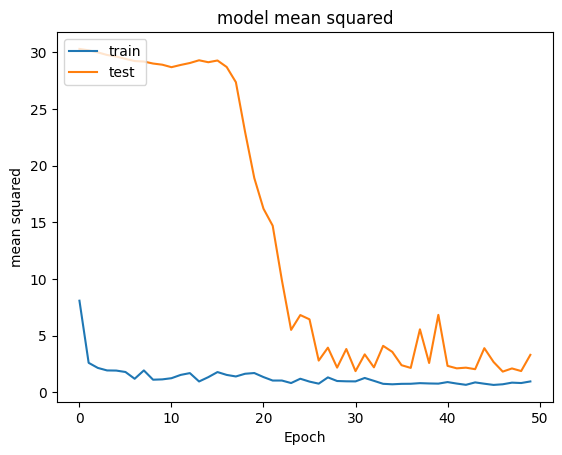

In [23]:
plt.plot(history.history['mae'][display_epochs[0]:display_epochs[1]])
plt.plot(history.history['val_mae'][display_epochs[0]:display_epochs[1]])
plt.title('model mean squared')
plt.ylabel('mean squared')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

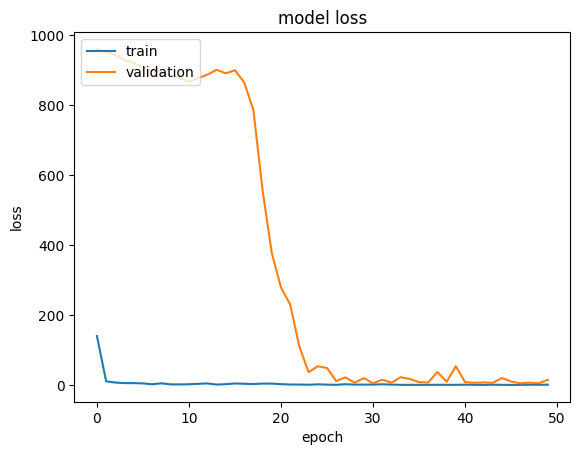

In [24]:
plt.plot(history.history['loss'][display_epochs[0]:display_epochs[1]])
plt.plot(history.history['val_loss'][display_epochs[0]:display_epochs[1]])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Bibliografia

- Deep Learning with Python, Second Edition. François Chollet